# ML Forecasting
This notebook explores the perfromance of different algorithims for forecasting stock price (closing).

## Data Download

In [1]:
import yfinance as yf
from datetime import date, timedelta
from random import seed

stock = 'SPY'
years_lookback = 10
seed(100)

df = yf.download(stock, end = date.today(), start = date.today() - timedelta(days = 365 * years_lookback))
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
#df.reset_index(inplace = True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2011-11-23,116.559998
2011-11-25,116.339996
2011-11-28,119.709999
2011-11-29,120.050003
2011-11-30,124.989998


## Data Exploration

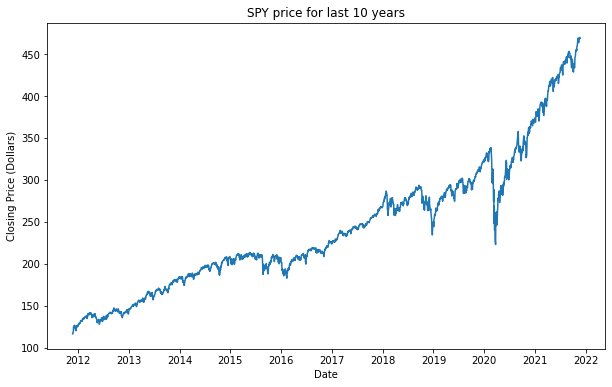

In [2]:
# plot closing price over time
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(10,6))
plt.plot(df.index, df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price (Dollars)')
plt.title(f'{stock} price for last {years_lookback} years')
plt.show()

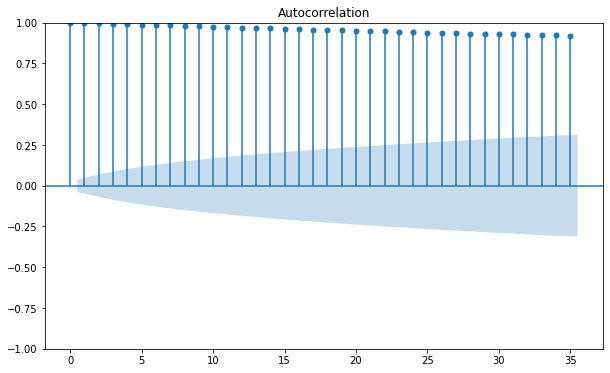

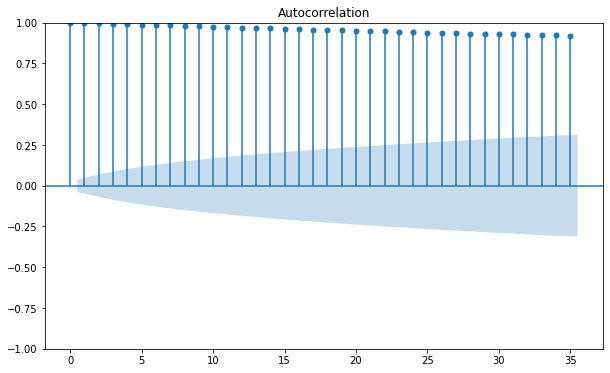

In [3]:
# plot auto correlation
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['Close'])

/home/stock_ml/Documents/python/ml_forecasting/env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


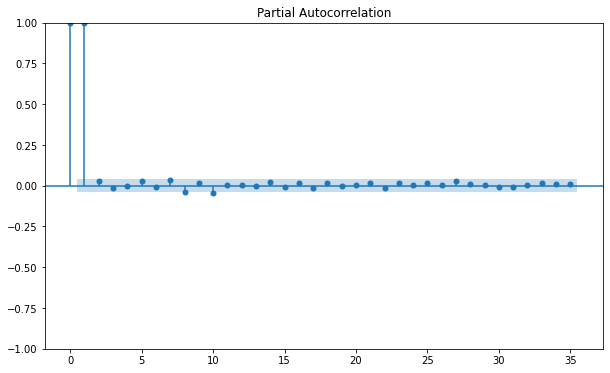

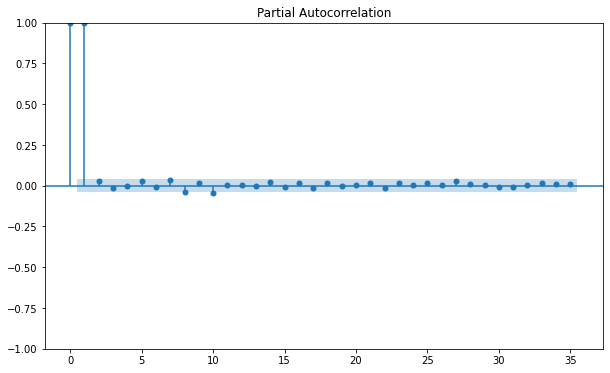

In [4]:
# plot partial auto correlation
import statsmodels.api as sm
plt.rc("figure", figsize=(10,6))
sm.graphics.tsa.plot_pacf(df['Close'])

## Feature Egineering

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

df = df.sort_index()

# date & seasonality features
df['day_of_year'] = df.index.dayofyear
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek

# closing price for previous n days
for lags in range(1,30):
    df[f'close_lag_{lags}'] = df.Close.shift(lags)

# simple moving average for previous n days
for window in [5,10,30,60,90]:
    df[f'close_sma_{window}'] = df['Close'].rolling(window).mean()

# apply simple exp. smoothing prediction
for alpha in [0.2,0.4,0.6,0.8,None]:
    se = SimpleExpSmoothing(df['Close'])
    se_fitted = se.fit(smoothing_level = alpha)
    df[f'close_ses_{alpha}'] = se_fitted.predict(0)

df.dropna(inplace = True)
df

/home/stock_ml/Documents/python/ml_forecasting/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/stock_ml/Documents/python/ml_forecasting/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/stock_ml/Documents/python/ml_forecasting/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/stock_ml/Documents/python/ml_fo

,Close,day_of_year,day_of_month,day_of_week,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,...,close_sma_5,close_sma_10,close_sma_30,close_sma_60,close_sma_90,close_ses_0.2,close_ses_0.4,close_ses_0.6,close_ses_0.8,close_ses_None
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-03,141.259995,94,3,1,141.839996,140.809998,140.229996,140.470001,141.169998,141.610001,...,140.921997,140.644998,138.816000,135.710000,131.844444,140.665687,141.104301,141.364958,141.613849,141.707406
2012-04-04,139.860001,95,4,2,141.259995,141.839996,140.809998,140.229996,140.470001,141.169998,...,140.799997,140.609998,138.943667,135.907333,132.103333,140.784548,141.166578,141.301980,141.330765,141.314150
2012-04-05,139.789993,96,5,3,139.860001,141.259995,141.839996,140.809998,140.229996,140.470001,...,140.711996,140.668997,139.049000,136.085000,132.363889,140.599639,140.643947,140.436792,140.154154,140.036014
2012-04-09,138.220001,100,9,0,139.789993,139.860001,141.259995,141.839996,140.809998,140.229996,...,140.193997,140.525998,139.092000,136.235333,132.569555,140.437710,140.302366,140.048713,139.862825,139.819772
2012-04-10,135.899994,101,10,1,138.220001,139.789993,139.860001,141.259995,141.839996,140.809998,...,139.005997,139.954997,139.049999,136.341833,132.745667,139.994168,139.469420,138.951486,138.548566,138.413641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,467.429993,319,15,0,467.269989,463.769989,463.619995,467.380005,468.929993,468.529999,...,465.893994,466.045996,453.228332,448.646667,445.475555,464.543422,465.877741,466.109469,466.596281,466.851128
2021-11-16,469.279999,320,16,1,467.429993,467.269989,463.769989,463.619995,467.380005,468.929993,...,466.273993,466.783997,454.434331,449.013667,445.833333,465.120736,466.498642,466.901783,467.263250,467.359926
2021-11-17,468.140015,321,17,2,469.279999,467.429993,467.269989,463.769989,463.619995,467.380005,...,467.177997,467.125998,455.542332,449.349834,446.195000,465.952589,467.611185,468.328713,468.876649,469.047589


## Train Test Split
create train test split function

In [6]:
from datetime import timedelta

def train_test_split(df, last_n_days: int):
    test = df[df.index >= df.index.max() - timedelta(days = last_n_days)]
    train = df[df.index < df.index.max() - timedelta(days = last_n_days)]
    return train, test

def x_y_split(df):
    x = df.drop(['Close'], axis = 1)
    y = df['Close']
    return x, y

test_days = 90

## LSTM Model

2021-11-20 22:00:20.171289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-20 22:00:20.171321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-20 22:00:21.402980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 22:00:21.403309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-20 22:00:21.403375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

Epoch 1/500
27/27 [==============================] - 7s 61ms/step - loss: 0.1515
Epoch 2/500
27/27 [==============================] - 2s 65ms/step - loss: 0.1422
Epoch 3/500
27/27 [==============================] - 2s 62ms/step - loss: 0.1285
Epoch 4/500
27/27 [==============================] - 2s 63ms/step - loss: 0.1054
Epoch 5/500
27/27 [==============================] - 2s 61ms/step - loss: 0.0682
Epoch 6/500
27/27 [==============================] - 2s 64ms/step - loss: 0.0450
Epoch 7/500
27/27 [==============================] - 2s 64ms/step - loss: 0.0442
Epoch 8/500
27/27 [==============================] - 2s 64ms/step - loss: 0.0437
Epoch 9/500
27/27 [==============================] - 2s 65ms/step - loss: 0.0330
Epoch 10/500
27/27 [==============================] - 2s 64ms/step - loss: 0.0096
Epoch 11/500
27/27 [==============================] - 2s 67ms/step - loss: 0.0056
Epoch 12/500
27/27 [==============================] - 2s 65ms/step - loss: 0.0033
Epoch 13/500
27/27 [=====

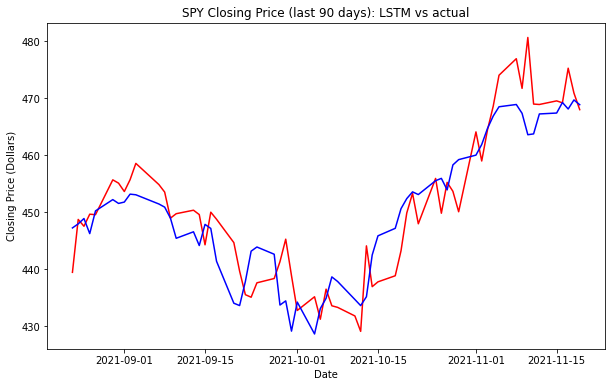

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from copy import deepcopy
import numpy as np
import pandas as pd

# min max scale numeric data
df_ker = deepcopy(df)
scaler = MinMaxScaler()
numeric_cols = [col for col in df_ker if not col.startswith('day')]
df_ker[numeric_cols] = scaler.fit_transform(df_ker[numeric_cols])

# one hot encode function
def onehotencode(df, col_to_encode: list):
    return pd.get_dummies(df, columns = col_to_encode, prefix = col_to_encode)\

# one hot encode encoded date cols
ohe_cols = [col for col in df_ker if col.startswith('day')]
df_ker = onehotencode(df_ker, ohe_cols)

# train test split
train_ker, test_ker = train_test_split(df_ker, test_days)
x_train_ker, y_train_ker = x_y_split(train_ker)
x_test_ker, y_test_ker = x_y_split(test_ker)

# reshape training data for LSTM
x_train_ker = x_train_ker.to_numpy().reshape(x_train_ker.shape[0], 1, x_train_ker.shape[1])
x_test_ker = x_test_ker.to_numpy().reshape(x_test_ker.shape[0], 1, x_test_ker.shape[1])

# define model
def lstm_build(layers:int, n_timesteps:int, n_features:int, learning_rate:float): 
    adam = Adam(learning_rate = learning_rate)
    model = Sequential()
    for _ in range(layers - 1):
        model.add(LSTM(x_train_ker.shape[2], activation='relu', input_shape = (n_timesteps, n_features), return_sequences = True))
        #model.add(Dropout(drop_out))
    model.add(LSTM(x_train_ker.shape[2], activation='relu', input_shape = (n_timesteps, n_features)))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = adam)
    return model

lstm = lstm_build(10, x_train_ker.shape[1], x_train_ker.shape[2], 0.0001)

# train
early_stop = EarlyStopping(monitor = 'loss', patience = 10)
lstm.fit(x_train_ker, y_train_ker, epochs = 500, batch_size = 90, callbacks = [early_stop])

# predict & results
df_ker_pred = deepcopy(test_ker)
df_ker_test = deepcopy(test_ker)
df_ker_pred['Close'] = lstm.predict(x_test_ker)
df_ker_pred[numeric_cols] = scaler.inverse_transform(df_ker_pred[numeric_cols])
df_ker_test[numeric_cols] = scaler.inverse_transform(df_ker_test[numeric_cols])
rmse_ker = np.sqrt(mse(df_ker_pred['Close'], df_ker_test['Close']))
mape_ker = mape(df_ker_pred['Close'], df_ker_test['Close'])
print(f'LSTM RMSE: {rmse_ker}')
print(f'LSTM MAPE: {mape_ker}')

# show results
plt.plot(df_ker_pred.index, df_ker_pred['Close'], color = 'red')
plt.plot(df_ker_test.index, df_ker_test['Close'], color = 'blue')
plt.xlabel('Date')
plt.ylabel('Closing Price (Dollars)')
plt.title(f'{stock} Closing Price (last {test_days} days): LSTM vs actual')
plt.show()

## XGboost Modelling

XGBoost RMSE: 16.532660861512728
XGBoost MAPE: 0.029452883408867696


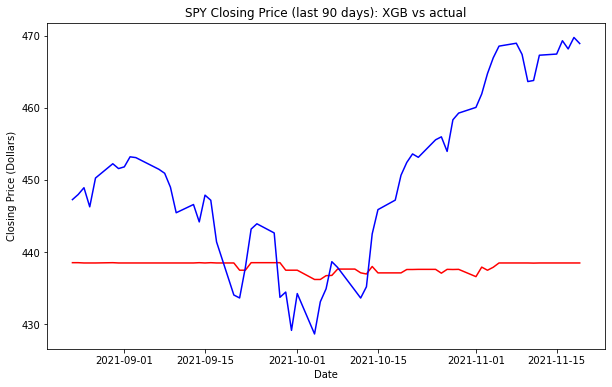

In [8]:
from xgboost import XGBRegressor

# train test split
train_xgb, test_xgb = train_test_split(df, test_days)
x_train_xgb, y_train_xgb = x_y_split(train_xgb)
x_test_xgb, y_test_xgb = x_y_split(test_xgb)

xgb = XGBRegressor(objective = 'reg:squarederror', n_estimators = 500, eta = 0.01, n_jobs = -1)
xgb.fit(x_train_xgb, y_train_xgb)
y_pred_xgb = xgb.predict(x_test_xgb)
rmse_xgb = np.sqrt(mse(y_test_xgb, y_pred_xgb))
mape_xgb = mape(y_test_xgb, y_pred_xgb)
print(f'XGBoost RMSE: {rmse_xgb}')
print(f'XGBoost MAPE: {mape_xgb}')

# show results
plt.plot(test_xgb.index, y_pred_xgb, color = 'red')
plt.plot(test_xgb.index, y_test_xgb, color = 'blue')
plt.xlabel('Date')
plt.ylabel('Closing Price (Dollars)')
plt.title(f'{stock} Closing Price (last {test_days} days): XGB vs actual')
plt.show()